In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import GPT
from tokenizers import Tokenizer

from utils import BatchLoader, estimate_loss, train_loop

# hyperparameters
batch_size = 16  # number of independent sequences that'll be processed in parallel
block_size = 128  # maximum context length for the preds
max_iters = 1000
eval_interval = 200
learning_rate = 3e-4
device = "mps" if torch.backends.mps.is_available() else "cpu"
eval_iters = 200
n_embd = 128
n_head = 4
n_blocks = 4
dropout = 0.2
# --------------

torch.manual_seed(1337)

# data preparation
text = open("tinyshakespeare.txt", "r").read()
# set up the vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
tokenizer = Tokenizer(chars)

data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

n = int(0.9 * len(data))  # first 90% will be the training set
n1 = int(0.98 * len(data))  # 90-98% will be the validation set and the last 2% will be the calibration set for the paper

train_data = data[:n]
val_data = data[n:n1]
calibrate_data = data[n1:]

train_loader = BatchLoader(train_data, block_size, batch_size, device, name="train")
val_loader = BatchLoader(val_data, block_size, batch_size, device, name="val")
calibration_loader = BatchLoader(calibrate_data, block_size, batch_size, device, name="calibrate")


UNIFORM BASELINE:  4.174387454986572


step 800: train loss 2.3344, val loss 2.3397: 100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


training is done!

AT:
Yond tor mucic! im wireer to: kret souead thyertisls for fire
Ththes ivetre y Roup ar
Se owe soull, torend, o donwondy I nerdo-ncad bed cr oue I e whargw
the:
And ithiave d yesor'sorerd
Nonjo tu velothau lagr f ou y, grtharnd acereay marlbm,
Wesugrerou I s wind
TI We opalery rouce noulimongau medngh s rt?.
De teig, chon atalfe yo e I toofunneeld we ineeache fe'se,
Tarae my rugor, cvedalletoul wis!
Wel b, my thel fof fre Cor, swe! n wooove:

Tlome an cattorer ba thenston an wlowhos, cof bor r


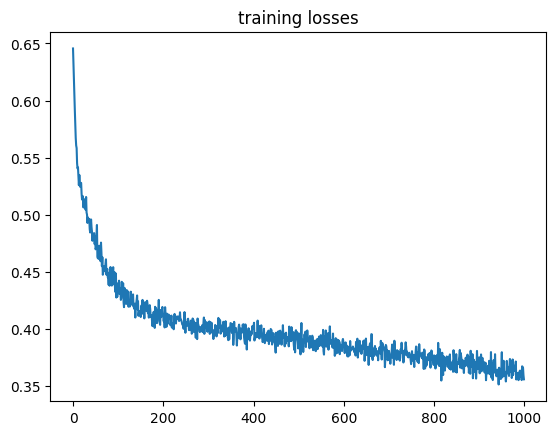

In [1]:
model = GPT(vocab_size, block_size, n_embd, n_head, n_blocks, device, dropout)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

training_losses = train_loop(model, optimizer, vocab_size, train_loader, [train_loader, val_loader], max_iters, eval_interval, eval_iters)

print("training is done!")

plt.title("training losses")
plt.plot(training_losses)
plt.savefig("training_losses.png")

idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(idx, max_new_tokens=500)[0].tolist()))

In [2]:
from utils import save

model_params = {
    "vocab_size": vocab_size,
    "block_size": block_size,
    "n_embd": n_embd,
    "n_head": n_head,
    "n_blocks": n_blocks,
    "dropout": dropout,
    "device": device
}

# save(model, tokenizer, model_params, "model")

In [3]:
from utils import load

In [4]:
loaded_model, tokenizer = load(GPT, "model")
loaded_model.to(device);

/Users/alperiox/Desktop/coding/paper-implts/Compact_Language_Models_240714679/utils.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sav

In [183]:
def attn_head_importance_hook(module, ins, outs) -> None:
    """ calculates the multi-head-attention layer's importance per head """

    # outs.shape = (B, T, E) where B: batch_size, T: num tokens, E: embedding size
    # the importance is calculated as summing the L2 norm of the attn outputs on B and T dimensions
    outs_flat = outs.view(-1, outs.shape[-1]) # (b,t,e) -> (b*t, e)
    print(outs_flat.shape)
    importance = torch.linalg.vector_norm(outs_flat.detach().cpu(), ord=2, dim=-1).sum().item()
    print("module:", module.__class__.__name__, end=" ")
    print("importance:", importance)

def neuron_importance_hook(module, ins, outs) -> None:
    """ calculates the neuron importance for the given layer """ 
    
    # for each neuron in the ffwd layer, we will simply sum up the output columns
    # as they're the activations of individual neurons
    
    print("module:", module.__class__.__name__)
    print("outs.shape:", outs.shape)
    # calculate the importances
    # importance = outs.detach().sum()
    importance = outs.detach().cpu().sum(dim=(0,1))
    print("importance:", importance)

def embedding_importance_hook(module, ins, outs) -> None:
    pass

for k in loaded_model.blocks[0].sa._forward_hooks:
    loaded_model.blocks[0].sa._forward_hooks.pop(k)

for k in loaded_model.blocks[0].ffwd._forward_hooks:
    loaded_model.blocks[0].ffwd._forward_hooks.pop(k)


loaded_model.blocks[0].sa.register_forward_hook(attn_head_importance_hook)
loaded_model.blocks[0].ffwd.register_forward_hook(neuron_importance_hook)

IndentationError: expected an indented block after function definition on line 25 (3091952094.py, line 28)

In [182]:
x = torch.randint(0, 10, (2, 4, 6))
w = torch.randint(0, 10, (6, 3))

y1 = x @ w
y2 = x @ w[:, 0]

s = []
for k in range(3):
    s.append((x @ w[:, k]).sum())
s = torch.tensor(s)


y1[:, :, 0], y2, s, y1.sum(dim=(0,1))

(tensor([[127,  86,  92, 104],
         [112, 142,  98,  70]]),
 tensor([[127,  86,  92, 104],
         [112, 142,  98,  70]]),
 tensor([ 831, 1043,  803]),
 tensor([ 831, 1043,  803]))

In [73]:
m = torch.randn((20, 128))
x = torch.randn((3, 5, 128))

y = x@m.T

y.shape

torch.Size([3, 5, 20])

In [61]:
loaded_model(torch.randn(2, 8, dtype=torch.long, device=device))

torch.Size([16, 128])
module: MultiHeadAttention importance: 216.15101623535156
module: FeedForward
outs.shape: torch.Size([2, 8, 128])


(tensor([[[-0.2285, -0.3694, -2.8513,  ..., -1.0546, -1.0449, -1.6349],
          [-0.0925, -0.8718, -2.8287,  ..., -1.2850, -0.9231, -0.9854],
          [-0.7184, -0.8731, -3.2450,  ..., -0.9555,  0.0066, -0.9769],
          ...,
          [-3.6906, -2.0997, -3.8406,  ..., -1.7566,  1.6518, -2.2227],
          [ 0.4982, -1.6967, -3.4054,  ..., -1.5614, -0.4943, -1.1255],
          [-3.8124, -2.3708, -3.7444,  ..., -1.4109,  1.2562, -1.7253]],
 
         [[-0.6952, -0.5611, -2.7724,  ..., -1.6762, -1.1417, -1.9604],
          [-3.9608, -1.9163, -3.5712,  ..., -1.8875,  1.5891, -2.3735],
          [ 0.2916, -1.3041, -3.0279,  ..., -0.5349, -0.7289, -1.1095],
          ...,
          [-0.1782, -1.1779, -2.4860,  ..., -1.2268, -0.1441, -0.6947],
          [-3.3343, -2.3166, -3.8581,  ..., -2.0056,  1.3442, -1.9407],
          [-0.3262, -1.6235, -2.1778,  ..., -1.0887, -0.8047, -1.5965]]],
        device='mps:0', grad_fn=<LinearBackward0>),
 None)